# Machine Learning Price Prediction Trading Strategy

In [1]:
# Import libraries
import math  
import pandas_datareader as web  
import yfinance as yf  
import datetime  
import numpy as np  
import pandas as pd 
import scipy.stats as stats 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler  
from keras.models import Sequential  
from keras.layers import Dense, LSTM  
from sklearn.model_selection import TimeSeriesSplit

## Get data for OMXC25 via Yahoo API

In [2]:
# Define the date range for data retrieval
start_date = datetime.datetime(2016, 1, 1)
end_date = datetime.datetime(2023, 1, 1)

# Fetch S&P500 data using Yahoo Finance
omx = yf.Ticker('^OMXC25')
omx_data = omx.history(period="1d", start=start_date, end=end_date)

# Remove the time zone information from the date index
omx_data.index = omx_data.index.date

# Remove the specified columns and reorder the remaining ones
df = omx_data[['High', 'Low', 'Open', 'Close', 'Volume']]  

# Display the DataFrame
df 

,High,Low,Open,Close,Volume
2016-12-19,1003.570007,993.679993,999.580017,999.739990,0
2016-12-20,1005.789978,999.190002,999.760010,1002.299988,0
2016-12-21,1005.440002,1000.179993,1002.320007,1002.969971,0
2016-12-22,1007.460022,1000.510010,1002.890015,1005.729980,0
2016-12-23,1009.599976,1003.780029,1005.669983,1007.369995,0
...,...,...,...,...,...
2022-12-23,1701.520020,1685.209961,1686.979980,1695.199951,7560500
2022-12-27,1709.910034,1698.150024,1701.160034,1701.630005,5433400
2022-12-28,1707.079956,1693.160034,1702.770020,1695.209961,6937600
2022-12-29,1712.839966,1688.589966,1691.430054,1712.839966,7364700


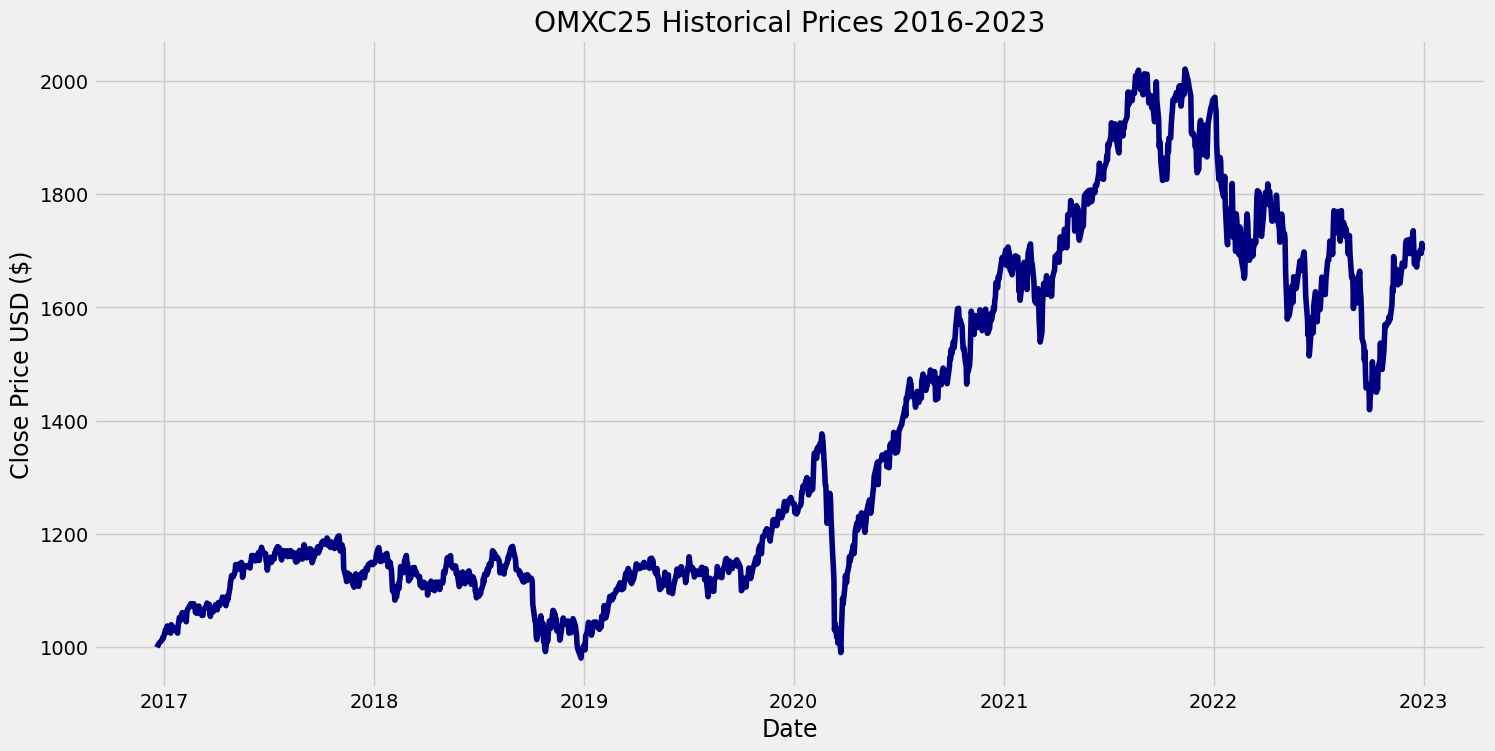

In [3]:
# Style the plots
plt.style.use('fivethirtyeight')

# Create a figure for the plot
plt.figure(figsize=(16, 8))

# Set the title for the plot
plt.title('OMXC25 Historical Prices 2016-2023')

# Plot the closing prices over time
plt.plot(df['Close'], color='navy')

# Label the x-axis and y-axis
plt.xlabel('Date', fontsize=17)
plt.ylabel('Close Price USD ($)', fontsize=17)

# Display the plot
plt.show()

## Build and train the LSTM model

In [4]:
# Create a new DataFrame with only the 'Close' column
data = df.filter(['Close'])

# Convert the DataFrame to a NumPy array
dataset = data.values

# Determine the number of rows for training the model (80% of the data)
training_data_len = math.ceil(len(dataset) * 0.8)

# Print the calculated training data length
print(training_data_len)

# Create a Min-Max scaler object with a specified feature range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the dataset and store it in a new variable
scaled_data = scaler.fit_transform(dataset)

# Print the scaled data
print(scaled_data)

# Create the training data set
train_data = scaled_data[0:training_data_len, :]

# Initialize empty lists for training data and labels
x_train = []  # Input sequences
y_train = []  # Corresponding output values

# Iterate through the data to create training sequences
for i in range(60, len(train_data)):
    # Create input sequence with the previous 60 data points
    x_train.append(train_data[i-60:i, 0])
    
    # Create the corresponding output value
    y_train.append(train_data[i, 0])

    # Print the input sequences and labels for the first iteration
    if i <= 60:
        print(x_train)
        print(y_train)
        print()

1176
[[0.01826066]
 [0.02072234]
 [0.02136659]
 ...
 [0.68702041]
 [0.70397331]
 [0.69216503]]
[array([0.01826066, 0.02072234, 0.02136659, 0.0240206 , 0.02559763,
       0.02980941, 0.0308287 , 0.03455969, 0.0337808 , 0.04821434,
       0.04330061, 0.05215685, 0.05465697, 0.0488009 , 0.04380065,
       0.05146453, 0.04250241, 0.05666679, 0.05077221, 0.04769504,
       0.05072408, 0.05071446, 0.0437814 , 0.04251203, 0.05585896,
       0.06150351, 0.06910976, 0.06481146, 0.06616734, 0.07729293,
       0.07186953, 0.07696602, 0.07021561, 0.06887898, 0.06168628,
       0.07711017, 0.08188938, 0.08734154, 0.08726465, 0.09042834,
       0.09237078, 0.08809161, 0.09241878, 0.09036096, 0.08815899,
       0.0772448 , 0.07593705, 0.07652361, 0.08806274, 0.08839939,
       0.08246631, 0.07808139, 0.07283112, 0.07373508, 0.07244646,
       0.08152397, 0.08584151, 0.08709152, 0.08875517, 0.09352464])]
[0.09123604268388019]



In [5]:
# Convert the x_train and y_train lists to NumPy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the training data to match the input requirements of an LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Print the shape of the reshaped training data
x_train.shape

(1116, 60, 1)

In [6]:
# Create an LSTM model
model = Sequential()

# Add the first LSTM layer with 50 units and return sequences
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Add the second LSTM layer with 50 units and do not return sequences
model.add(LSTM(50, return_sequences=False))

# Add a dense layer with 25 units
model.add(Dense(25))

# Add the output layer with a single unit for regression
model.add(Dense(1))

In [7]:
# Compile the LSTM model (Adaptive Moment Estimation)
model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
# Train the LSTM model with the training data
model.fit(x_train, y_train, batch_size=1, epochs=1)

1116/1116 [==============================] - 9s 7ms/step - loss: 0.0029


## Test the LSTM model and make predictions

In [9]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]

# Initialize empty lists for testing data and labels
x_test = []  # Input sequences
y_test = dataset[training_data_len:, :]  # Corresponding output values

# Iterate through the test data to create testing sequences
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [10]:
# Convert the testing input data to a NumPy array
x_test = np.array(x_test)

# Reshape the testing input data to match the input requirements of the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values for the test data
predictions = model.predict(x_test)

# Inverse transform the scaled predictions to their original scale
predictions = scaler.inverse_transform(predictions)

10/10 [==============================] - 0s 5ms/step


In [11]:
# Calculate the Root Mean Squared Error (RMSE) to evaluate the model's performance
rmse = np.sqrt(np.mean((predictions - y_test)**2))
rmse

59.79083472575808

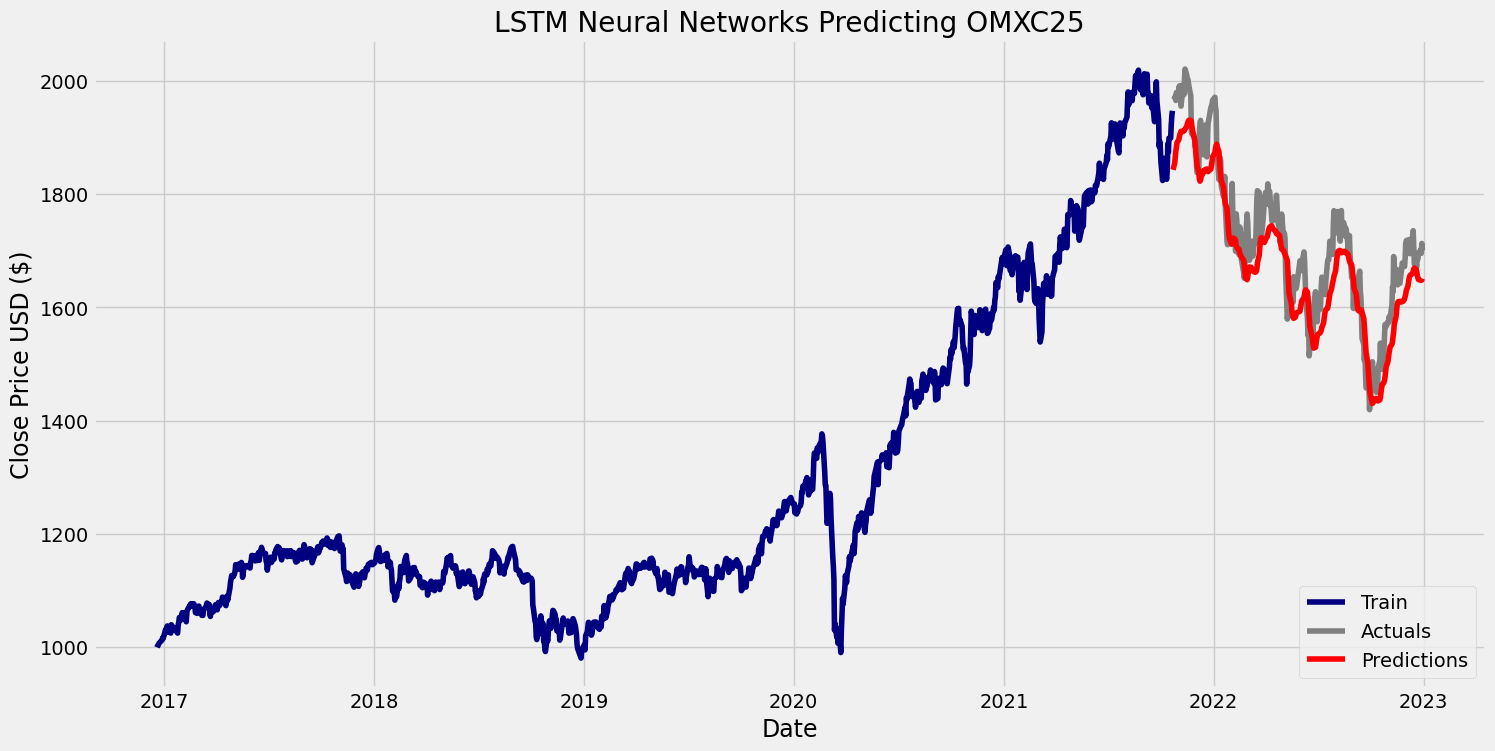

In [12]:
# Separate the data into training and validation sets
train = data[:training_data_len]
valid = data[training_data_len:]
valid = valid.copy()  # Create a copy to avoid the SettingWithCopyWarning
valid['Predictions'] = predictions  # Add predicted values to the 'valid' DataFrame

# Create a plot to visualize the data
plt.figure(figsize=(16, 8))
plt.title('LSTM Neural Networks Predicting OMXC25')
plt.xlabel('Date', fontsize=17)
plt.ylabel('Close Price USD ($)', fontsize=17)

# Plot the 'Close' prices from the training data
plt.plot(train['Close'], label='Train', color='navy')

# Plot the 'Close' prices from the validation data
plt.plot(valid['Close'], label='Actuals', color='grey')

# Plot the 'Predictions' from the validation data
plt.plot(valid['Predictions'], label='Predictions', color='red')

# Add a legend to the plot
plt.legend(loc='lower right')

# Display the plot
plt.show()

## Time series split cross validation

In [13]:
# Define the number of splits
n_splits = 5 

# Create a new DataFrame with only the 'Close' column
data = df.filter(['Close'])

# Convert the DataFrame to a NumPy array
dataset = data.values

# Create a Min-Max scaler object with a specified feature range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the dataset and store it in a new variable
scaled_data = scaler.fit_transform(dataset)

# Initialize the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lists to store RMSE values for each fold
rmse_values = []

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Iterate through the time series splits
for train_index, test_index in tscv.split(scaled_data):
    # Split the data into training and testing sets for this fold
    train_data, test_data = scaled_data[train_index], scaled_data[test_index]

    # Create the training data set
    x_train, y_train = [], []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i - 60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Create the testing data set
    x_test, y_test = [], []

    for i in range(60, len(test_data)):
        x_test.append(test_data[i - 60:i, 0])

    x_test, y_test = np.array(x_test), test_data[60:, 0]

    # Get the model's predicted price values for the test data
    predictions = model.predict(x_test)

    # Inverse transform the scaled predictions to their original scale
    predictions = scaler.inverse_transform(predictions)

    # Calculate the Root Mean Squared Error (RMSE) for this fold
    rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
    rmse_values.append(rmse)

# Calculate the average RMSE across all folds
average_rmse = np.mean(rmse_values)
print("Average RMSE:", average_rmse)

6/6 [==============================] - 0s 5ms/step
Average RMSE: 998.2586880574133


## Comparing the actual stock price with the predictions

In [14]:
# Calculate the daily percentage change in the actual close prices
valid['Actual_Pct_Change'] = valid['Close'].pct_change() * 100

# Create a new column 'Buy_Sell' based on the prediction strategy
valid['Buy_Sell'] = valid['Predictions'].shift(-1) > valid['Close']

# Calculate the daily percentage gain based on the strategy
valid['Strategy_Pct_Change'] = valid['Buy_Sell'].shift(1) * valid['Actual_Pct_Change']

# Calculate the cumulative percentage gain for the strategy
valid['Cumulative_Strategy_Gain'] = (1 + valid['Strategy_Pct_Change'] / 100).cumprod() - 1

# Calculate the cumulative percentage gain if holding the entire period
valid['Cumulative_Hold_Gain'] = (1 + valid['Actual_Pct_Change'] / 100).cumprod() - 1

# Print the last row of the DataFrame to get the final cumulative gains
final_cumulative_strategy_gain = valid['Cumulative_Strategy_Gain'].iloc[-1]
final_cumulative_hold_gain = valid['Cumulative_Hold_Gain'].iloc[-1]

print(f'Cumulative Percentage Gain with Strategy: {final_cumulative_strategy_gain:.2%}')
print(f'Cumulative Percentage Gain with Holding: {final_cumulative_hold_gain:.2%}')

Cumulative Percentage Gain with Strategy: -0.90%
Cumulative Percentage Gain with Holding: -13.52%


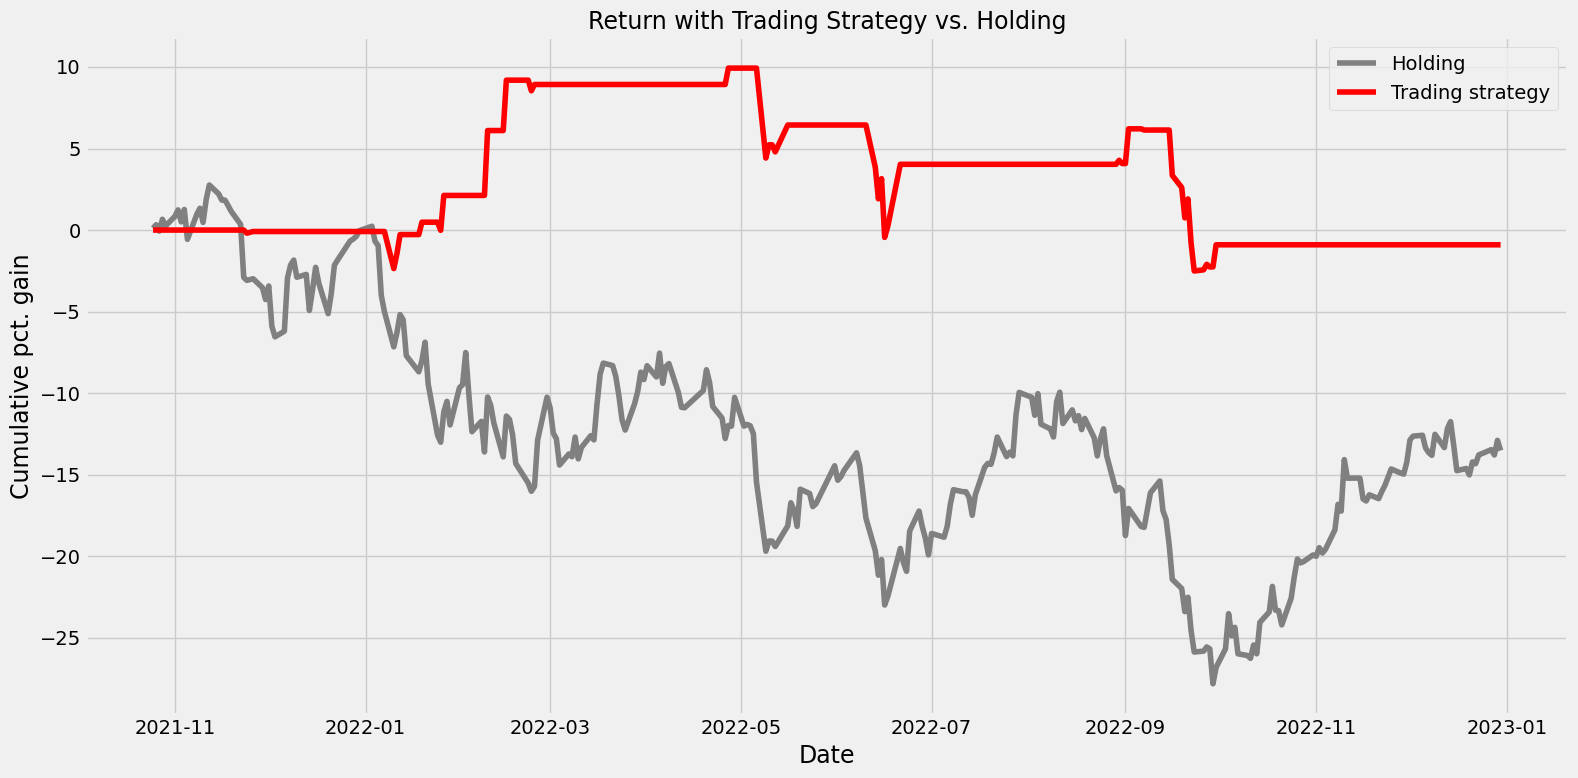

In [15]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the cumulative percentage gain for the actual stock price
ax.plot(valid.index, valid['Cumulative_Hold_Gain'] * 100, label='Holding', color='grey')

# Plot the cumulative percentage gain with predictions
ax.plot(valid.index, valid['Cumulative_Strategy_Gain'] * 100, label='Trading strategy', color='red')

# Set labels and title
ax.set_xlabel('Date', fontsize=17)
ax.set_ylabel('Cumulative pct. gain', fontsize=17)
ax.set_title('Return with Trading Strategy vs. Holding', fontsize=17)

# Add a legend
ax.legend()

# Add a grid
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [16]:
# Save the valid DataFrame to a CSV file
valid.to_csv('prediction_results_omx.csv', index=False)

In [17]:
# Skip the first row (header) and reset the index
valid = valid[1:].reset_index(drop=True)

# Calculate the percentage of correct predictions
correct_predictions = ((valid['Actual_Pct_Change'] > 0) & (valid['Strategy_Pct_Change'] == valid['Actual_Pct_Change'])) | ((valid['Actual_Pct_Change'] < 0) & (valid['Strategy_Pct_Change'] == 0))
percentage_correct = (correct_predictions.sum() / len(valid)) * 100

print(f'Percentage of correct predictions: {percentage_correct:.2f}%')

Percentage of correct predictions: 53.08%


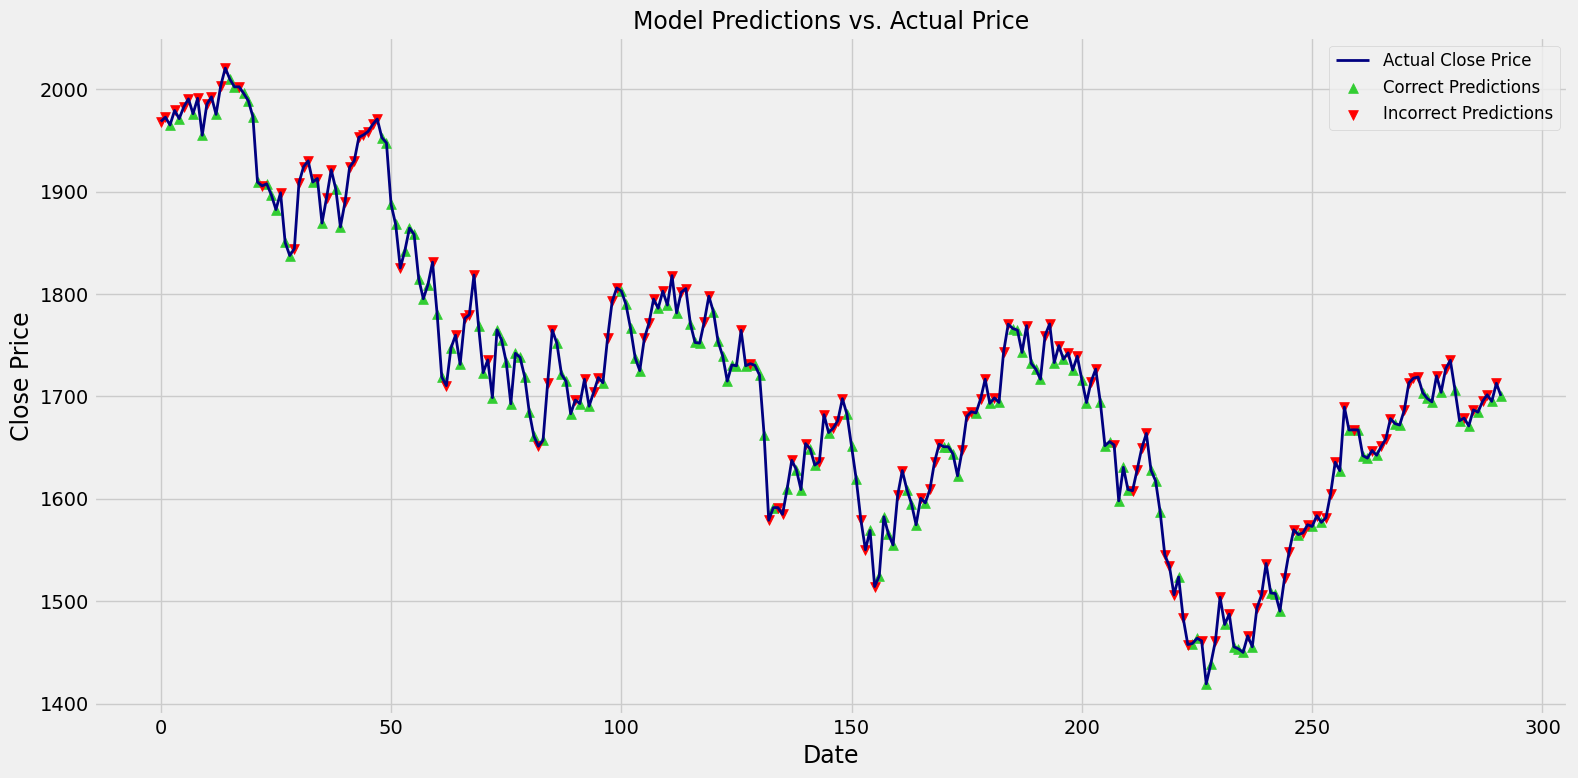

In [18]:
# Create a new column to represent correct and incorrect predictions
valid['Prediction_Type'] = 'Correct'
valid.loc[~correct_predictions, 'Prediction_Type'] = 'Incorrect'

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the actual close price
ax.plot(valid.index, valid['Close'], label='Actual Close Price', color='navy', linewidth=2)

# Plot correct predictions with green triangles (^)
ax.scatter(valid[valid['Prediction_Type'] == 'Correct'].index, valid[valid['Prediction_Type'] == 'Correct']['Close'],
            label='Correct Predictions', color='limegreen', marker='^', s=50)

# Plot incorrect predictions with red inverted triangles (v)
ax.scatter(valid[valid['Prediction_Type'] == 'Incorrect'].index, valid[valid['Prediction_Type'] == 'Incorrect']['Close'],
            label='Incorrect Predictions', color='red', marker='v', s=50)

# Set labels and title
ax.set_xlabel('Date', fontsize=17)
ax.set_ylabel('Close Price', fontsize=17)
ax.set_title('Model Predictions vs. Actual Price', fontsize=17)

# Add a legend
ax.legend(fontsize=12)

# Add a grid
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [19]:
# Skip the first row (header) and reset the index
valid = valid[1:].reset_index(drop=True)

# Calculate the percentage of correct predictions for Pct. Change > 1% or < -1%
condition = (valid['Actual_Pct_Change'] > 1) | (valid['Actual_Pct_Change'] < -1)
correct_predictions = ((condition) & (valid['Strategy_Pct_Change'] == valid['Actual_Pct_Change'])) | ((~condition) & (valid['Strategy_Pct_Change'] == 0))
percentage_correct = (correct_predictions.sum() / len(valid)) * 100

print(f'Percentage of correct predictions for Pct. Change > 1% or < -1%: {percentage_correct:.2f}%')


Percentage of correct predictions for Pct. Change > 1% or < -1%: 52.23%


In [20]:
# Skip the first row (header) and reset the index
valid = valid[1:].reset_index(drop=True)

# Create a new DataFrame with the top 10 biggest percentage changes
valid['Correct_Prediction'] = ((valid['Actual_Pct_Change'] > 0) & (valid['Strategy_Pct_Change'] == valid['Actual_Pct_Change'])) | ((valid['Actual_Pct_Change'] < 0) & (valid['Strategy_Pct_Change'] == 0))
top_10_positive_changes = valid.nlargest(10, 'Actual_Pct_Change')  # Top 10 positive changes
top_10_negative_changes = valid.nsmallest(10, 'Actual_Pct_Change')  # Top 10 negative changes

# Combine and sort the top changes
top_10_changes = pd.concat([top_10_positive_changes, top_10_negative_changes])
top_10_changes['Actual_Pct_Change'] = top_10_changes['Actual_Pct_Change'].apply(lambda x: f"{x:.6f}")

# Sort the DataFrame by the absolute values of 'Actual_Pct_Change'
top_10_changes['Actual_Pct_Change'] = top_10_changes['Actual_Pct_Change'].astype(float)
top_10_changes = top_10_changes.iloc[top_10_changes['Actual_Pct_Change'].abs().argsort()[::-1]]

# Display the resulting DataFrame without the index, limited to the top 10 rows
result_df = top_10_changes[['Actual_Pct_Change', 'Correct_Prediction']]
result_df = result_df.head(10)
print(result_df.to_string(index=False))

 Actual_Pct_Change  Correct_Prediction
         -5.015248               False
          3.896146                True
          3.818742               False
          3.790913                True
         -3.490537               False
          3.479719               False
         -3.450661                True
         -3.391830                True
          3.369937               False
         -3.304995                True


## Testing for statistical significance

In [21]:
# Extract the cumulative gains for the holding strategy and the strategy with predictions
cumulative_hold_gain = valid['Cumulative_Hold_Gain'].dropna().values
cumulative_strategy_gain = valid['Cumulative_Strategy_Gain'].dropna().values

# Calculate the mean and standard deviation for both strategies
mean_hold = cumulative_hold_gain.mean() * 100  # Multiply by 100 to express as a percentage
std_hold = cumulative_hold_gain.std() * 100    # Multiply by 100 to express as a percentage
mean_strategy = cumulative_strategy_gain.mean() * 100  # Multiply by 100 to express as a percentage
std_strategy = cumulative_strategy_gain.std() * 100    # Multiply by 100 to express as a percentage

# Perform a t-test
t_stat, p_value = stats.ttest_rel(cumulative_hold_gain, cumulative_strategy_gain)

# Define the significance level (alpha)
alpha = 0.05

# Check if the p-value is less than alpha to determine significance
if p_value < alpha:
    print(f'The t-test is statistically significant (p = {p_value:.2e}).')
    print('The two sets of returns have different means')
else:
    print(f'The t-test is not statistically significant (p = {p_value:.2e}).')
    print('The two sets of returns have the same mean')

# Print the t-value, mean, and standard deviation for both strategies as percentages
print(f'T-Value: {t_stat:.4f}')
#print(f'Mean Cumulative Gain (Holding): {mean_hold:.2f}%')
#print(f'Standard Deviation (Holding): {std_hold:.2f}%')
#print(f'Mean Cumulative Gain (Strategy): {mean_strategy:.2f}%')
#print(f'Standard Deviation (Strategy): {std_strategy:.2f}%')

The t-test is statistically significant (p = 8.10e-103).
The two sets of returns have different means
T-Value: -33.9357
